# Investigating FB ad.id

In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

import datautil as du
from analysis_util_01 import MMM, MMMChannelsStraight, MMMChannelsStraightConfounder, MMMFbGoogleMetrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
facebook = du.get_engineered_file('facebook')

## Distribution of conversion rates

In [77]:
facebook.head()

,date,ad_id,spend,reach,impressions,clicks,purchases,purchases_value,roas,ctr,cost_per_purchase,ad_id_date_first,ad_id_days_since_first_seen
0,2024-05-19,120202188355420590,35.71,1030,1116,46,0,0.00,0.000000,0.041219,NaN,2024-01-05,135
1,2024-05-19,120202188650350590,20.43,5463,5852,101,0,0.00,0.000000,0.017259,NaN,2024-01-22,118
2,2024-05-19,120202188650420590,41.88,7163,8141,188,0,0.00,0.000000,0.023093,NaN,2024-01-22,118
3,2024-05-19,120203048518460590,100.54,1619,1715,52,0,0.00,0.000000,0.030321,NaN,2024-01-30,110
4,2024-05-19,120204688537830590,216.71,3772,4452,198,1,165.68,0.764524,0.044474,216.71,2024-03-08,72


In [78]:
conv_rates = facebook.copy()
# group by ad_id and sum the conversions
conv_rates = conv_rates.groupby('ad_id')[['impressions', 'clicks', 'purchases']].sum().reset_index() 
conv_rates['cr_imp_click'] = conv_rates['clicks'] / conv_rates['impressions']
conv_rates['cr_click_purchase'] = conv_rates['purchases'] / conv_rates['clicks']
conv_rates['cr_imp_purchase'] = conv_rates['purchases'] / conv_rates['impressions']
conv_rates.head(20)

,ad_id,impressions,clicks,purchases,cr_imp_click,cr_click_purchase,cr_imp_purchase
0,23849013860970589,6898,80,1,0.011598,0.012500,0.000145
1,23849013861000589,3974,58,0,0.014595,0.000000,0.000000
2,23849013861020589,32063,146,0,0.004554,0.000000,0.000000
3,23849013861040589,4345,62,1,0.014269,0.016129,0.000230
4,23849013959450589,32856,319,2,0.009709,0.006270,0.000061
5,23849013981520589,9073,125,1,0.013777,0.008000,0.000110
6,23849013994470589,7537,231,0,0.030649,0.000000,0.000000
7,23849013994490589,83461,1995,2,0.023903,0.001003,0.000024
8,23849014016600589,14341,97,1,0.006764,0.010309,0.000070
9,23849014016640589,15855,103,0,0.006496,0.000000,0.000000


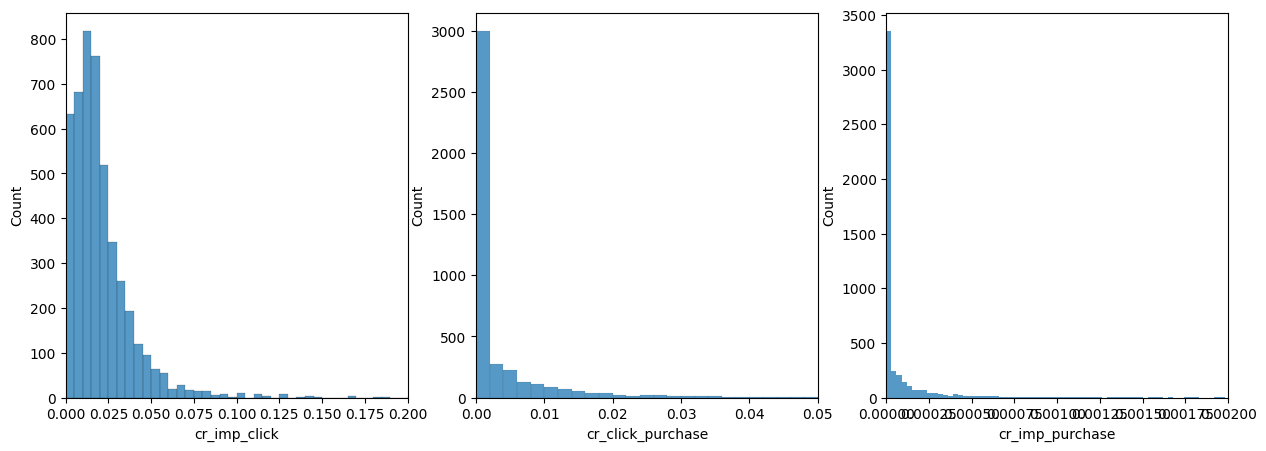

In [79]:
# plot the distributions of the conversion rates
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.kdeplot(data=conv_rates, x="cr_imp_click", fill=True, ax=ax[0])
# sns.kdeplot(data=conv_rates, x="cr_click_purchase", fill=True, ax=ax[1])
# sns.kdeplot(data=conv_rates, x="cr_imp_purchase", fill=True, ax=ax[2])
sns.histplot(conv_rates['cr_imp_click'], ax=ax[0], binwidth=0.005)
sns.histplot(conv_rates['cr_click_purchase'], ax=ax[1], binwidth=0.002)
sns.histplot(conv_rates['cr_imp_purchase'], ax=ax[2], binwidth=0.00003)
ax[0].set_xlim(left=0.0, right=0.2)
ax[1].set_xlim(left= 0.0, right=0.05)
ax[2].set_xlim(left= 0.0, right=0.002)
plt.show()

Quite a large spread of conversion rates

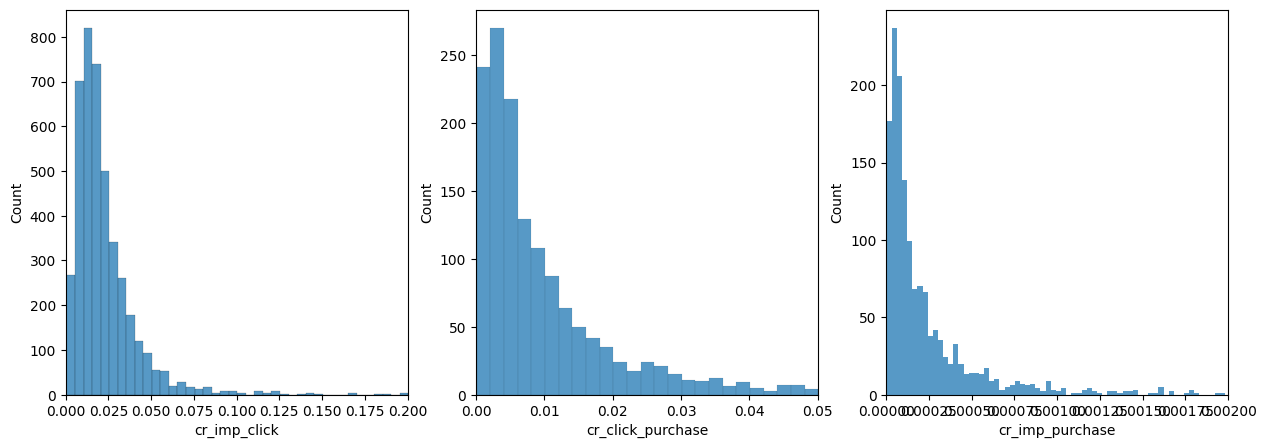

In [80]:
# exclude zero observations and plot the distributions of the conversion rates
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(conv_rates[conv_rates['cr_imp_click'] > 0]['cr_imp_click'], ax=ax[0], binwidth=0.005)
sns.histplot(conv_rates[conv_rates['cr_click_purchase'] > 0]['cr_click_purchase'], ax=ax[1], binwidth=0.002)
sns.histplot(conv_rates[conv_rates['cr_imp_purchase'] > 0]['cr_imp_purchase'], ax=ax[2], binwidth=0.00003)
ax[0].set_xlim(left=0.0, right=0.2)
ax[1].set_xlim(left= 0.0, right=0.05)
ax[2].set_xlim(left= 0.0, right=0.002)
plt.show()

## Correlation between the conversion rates
imp to click has a fairly strong correlation with click to purchase, so maybe an interesting predictor or early indicator of a strong campaign here.

<Axes: >

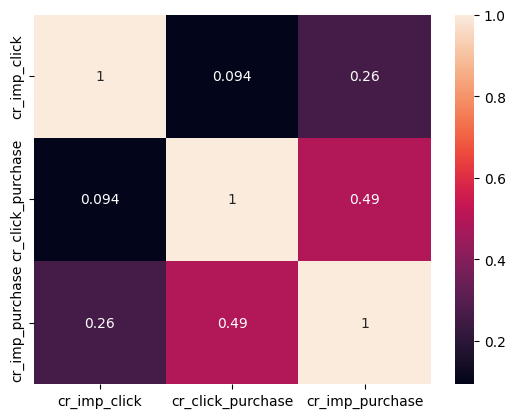

In [81]:
# correlate the conversion rates
conv_rates[['cr_imp_click', 'cr_click_purchase', 'cr_imp_purchase']].corr()
# plot the correlation matrix
sns.heatmap(conv_rates[['cr_imp_click', 'cr_click_purchase', 'cr_imp_purchase']].corr(), annot=True)

(0.0, 0.05)

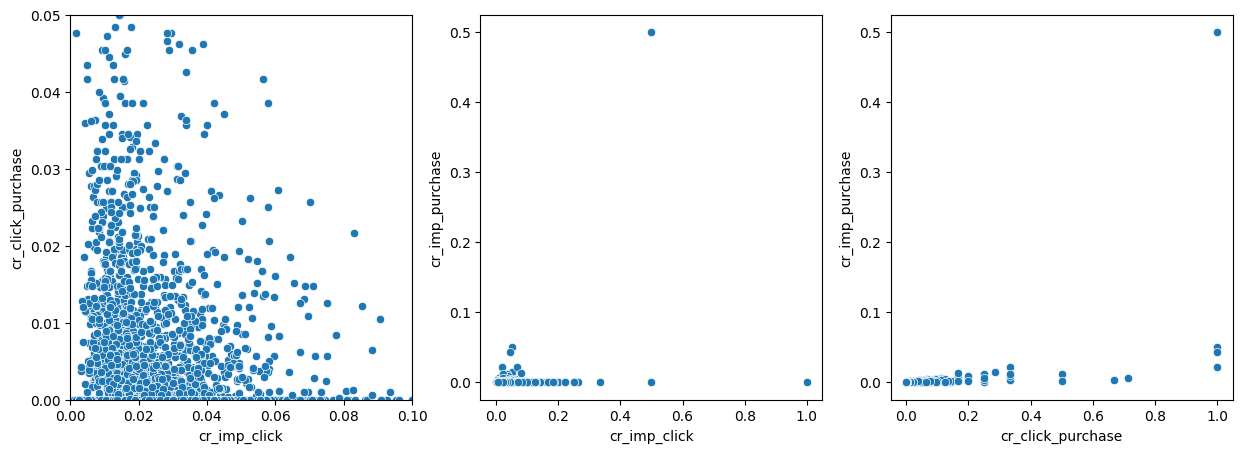

In [82]:
# make a scatter plot of the conversion rates
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(data=conv_rates, x='cr_imp_click', y='cr_click_purchase', ax=ax[0])
sns.scatterplot(data=conv_rates, x='cr_imp_click', y='cr_imp_purchase', ax=ax[1])
sns.scatterplot(data=conv_rates, x='cr_click_purchase', y='cr_imp_purchase', ax=ax[2])
ax[0].set_xlim(left=0.0, right=0.1)
ax[0].set_ylim(bottom=0.0, top=0.05)

In [83]:
sums = facebook.groupby('ad_id')[['impressions', 'clicks', 'purchases']].sum().reset_index()
sums

,ad_id,impressions,clicks,purchases
0,23849013860970589,6898,80,1
1,23849013861000589,3974,58,0
2,23849013861020589,32063,146,0
3,23849013861040589,4345,62,1
4,23849013959450589,32856,319,2
...,...,...,...,...
4705,120207871303800590,1588,4,0
4706,120207871312370590,12479,170,0
4707,120207874169950590,19266,460,0
4708,120207877286230590,8173,189,0


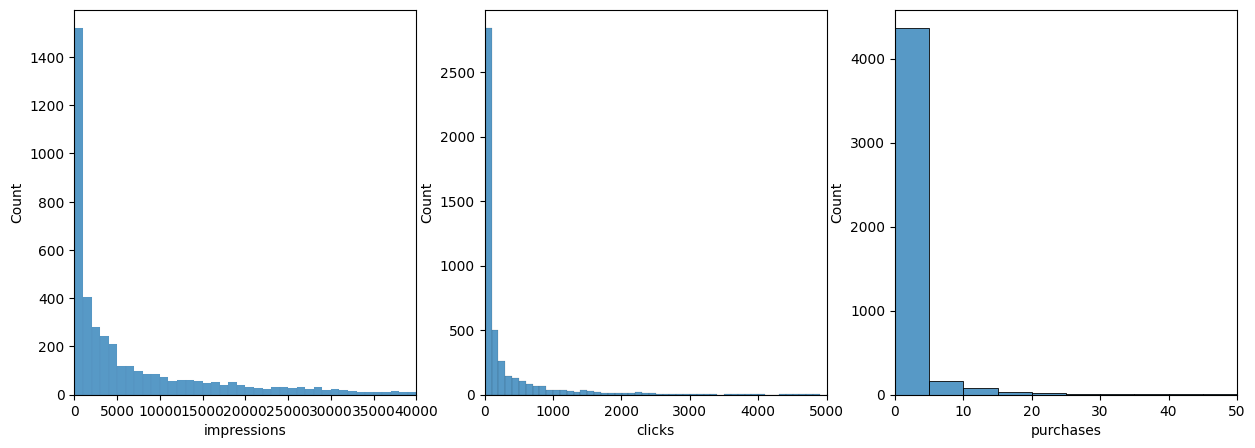

In [84]:
# plot histograms of the sums
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(sums['impressions'], ax=ax[0], binwidth=1000)
sns.histplot(sums['clicks'], ax=ax[1], binwidth=100)
sns.histplot(sums['purchases'], ax=ax[2], binwidth=5)
ax[0].set_xlim(left=0.0, right=4e4)
ax[1].set_xlim(left=0.0, right=5000)
ax[2].set_xlim(left=0.0, right=50)

plt.show()

In [85]:
# aggregate the sums over ad_id_days_since_first_seen
sums_delay = facebook.groupby(['ad_id_days_since_first_seen'])[['impressions', 'clicks', 'purchases']].sum().reset_index()
sums_delay

,ad_id_days_since_first_seen,impressions,clicks,purchases
0,0,7481694,174692,504
1,1,8519035,196322,682
2,2,7279797,153344,638
3,3,6838161,132552,637
4,4,5049800,93247,308
...,...,...,...,...
513,519,0,0,0
514,520,0,0,0
515,521,0,0,0
516,522,0,0,0


Fairly long tails in how long an ad_id is active

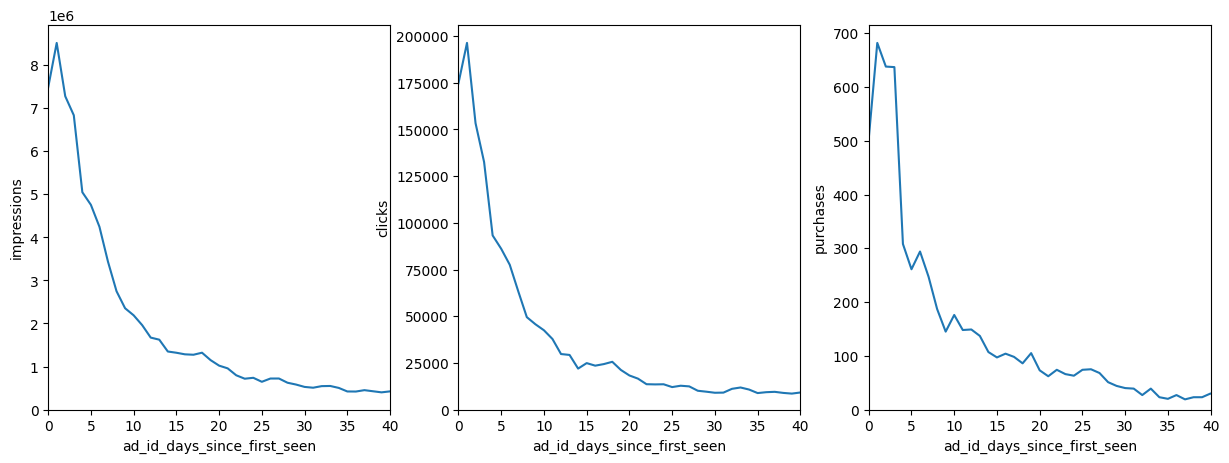

In [86]:
# plot the sums as a function of days since first seen
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='impressions', ax=ax[0])
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='clicks', ax=ax[1])
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='purchases', ax=ax[2])
ax[0].set_xlim(left=0.0, right=40)
ax[0].set_ylim(bottom=0.0)
ax[1].set_xlim(left=0.0, right=40)
ax[1].set_ylim(bottom=0.0)
ax[2].set_xlim(left=0.0, right=40)
ax[2].set_ylim(bottom=0.0)
plt.show()

The aggregated conversion rates are very stable over days since ad id is launched.

However, this could be an effect of the best campaigns being kept alive for a long time, so that the _individual_ campaigns really do decline in effect, only the aggregate seems stable for reason of contuing the best campaigns the longest.

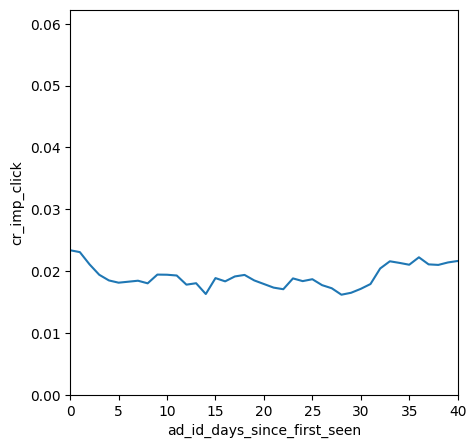

In [87]:
# calculate the conversion rates in the aggregated data
sums_delay['cr_imp_click'] = sums_delay['clicks'] / sums_delay['impressions']
# plot it
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='cr_imp_click', ax=ax)
ax.set_xlim(left=0.0, right=40)
ax.set_ylim(bottom=0.0)
plt.show()

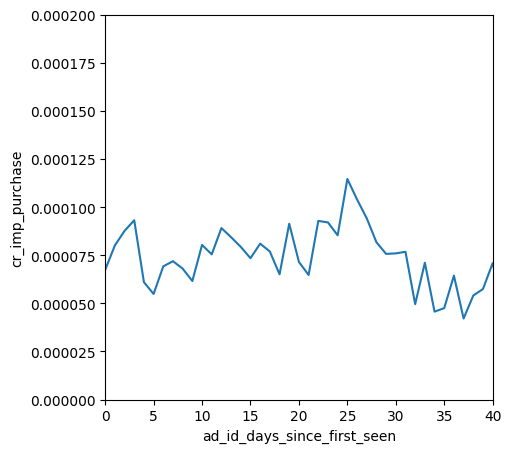

In [88]:
# same for impression to purchase conversion rate
sums_delay['cr_imp_purchase'] = sums_delay['purchases'] / sums_delay['impressions']
# plot it
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=sums_delay, x='ad_id_days_since_first_seen', y='cr_imp_purchase', ax=ax)
ax.set_xlim(left=0.0, right=40)
ax.set_ylim(bottom=0.0, top=0.0002)
plt.show()

But it also seems stable if we take only the 20 all-time most selling campaigns

In [89]:
# filter down to the best performing ads
# pick from sums_delay the 1% that have the highest total number of purchases
fb_sum_purchases_byadid = facebook.groupby('ad_id')['purchases'].sum().sort_values(ascending=False).reset_index()
best_ads = fb_sum_purchases_byadid.head(20)['ad_id']
# filter facebook down to the best ads
best_ads = facebook[facebook['ad_id'].isin(best_ads)]

sums_delay_best = best_ads.groupby(['ad_id_days_since_first_seen'])[['impressions', 'clicks', 'purchases']].sum().reset_index()
sums_delay_best

,ad_id_days_since_first_seen,impressions,clicks,purchases
0,0,134789,5341,40
1,1,298867,8985,87
2,2,379509,9805,94
3,3,500645,11360,131
4,4,164615,3996,33
...,...,...,...,...
512,519,0,0,0
513,520,0,0,0
514,521,0,0,0
515,522,0,0,0


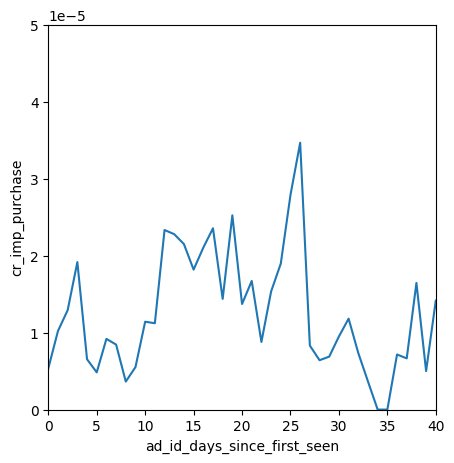

In [90]:
# calculate the conversion rates in the aggregated data
sums_delay_best['cr_imp_purchase'] = sums_delay_best['purchases'] / sums_delay['impressions']
# plot it
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.lineplot(data=sums_delay_best, x='ad_id_days_since_first_seen', y='cr_imp_purchase', ax=ax)
ax.set_xlim(left=0.0, right=40)
ax.set_ylim(bottom=0.0, top=0.00005)
plt.show()

# Modeling - Impression to click

In [91]:
# find ad_ids in facebook that have days with xx > yy and slim down the data to only those ad_ids
ad_ids = facebook[facebook['impressions'] >= 0]['ad_id'].unique()
# take a randomized sample from ad_ids
np.random.seed(42)
ad_ids = np.random.choice(ad_ids, 50)
# only keep the rows with ad_ids in ad_ids
facebook_slimmed = facebook[facebook['ad_id'].isin(ad_ids)].copy()
ad_ids.shape, facebook_slimmed.shape
# ad_ids

((50,), (1565, 13))

In [92]:
# add an index to the slimmed data for the ad_ids in the slimmed ad_id set, to be able to use them in the model
facebook_slimmed['ad_id_index'] = facebook_slimmed['ad_id'].apply(lambda x: list(ad_ids).index(x))
facebook_slimmed.head()

,date,ad_id,spend,reach,impressions,clicks,purchases,purchases_value,roas,ctr,cost_per_purchase,ad_id_date_first,ad_id_days_since_first_seen,ad_id_index
158,2024-05-19,120204871062580590,0.01,3,3,0,0,0.0,0.0,0.000000,NaN,2024-03-13,67,8
217,2024-05-19,120206186155640590,0.02,4,4,0,0,0.0,0.0,0.000000,NaN,2024-04-17,32,25
269,2024-05-19,120206609586940590,0.08,15,15,0,0,0.0,0.0,0.000000,NaN,2024-05-03,16,41
383,2024-05-20,120204871062580590,0.37,29,36,0,0,0.0,0.0,0.000000,NaN,2024-03-13,68,8
602,2024-05-19,120206390360220590,0.42,72,84,3,0,0.0,0.0,0.035714,NaN,2024-05-03,16,3


In [93]:

with pm.Model(coords={"ad_id": ad_ids}) as model_imp_click:
    # data
    impressions = pm.Data('impressions', facebook_slimmed['impressions'])
    # index of the ad in the ad_ids array - used for indexing the ad_id specific parameters
    ad_id_idx = facebook_slimmed['ad_id'].apply(lambda x: list(ad_ids).index(x))
    
    # hyperpriors
    # general conversion rate
    cr_imp_click_hyper = pm.Normal('cr_imp_click_hyper', mu=0.02, sigma=0.1)
    cr_imp_click_sigma_hyper = pm.HalfNormal('cr_imp_click_sigma_hyper', sigma=0.02)

    # ad_id specific conversion rate drawn from the general hyperprior conversion rate
    cr_imp_click = pm.Normal('cr_imp_click', mu=cr_imp_click_hyper, sigma=cr_imp_click_sigma_hyper, dims="ad_id")   
    
    # sigma for output likelihood
    sigma = pm.HalfNormal('sigma', sigma=0.02)

    # cr_imp_click[ad_id_idx] is the full vector of ad_id specific conversion rates for all observations
    mu = pm.Deterministic('mu', cr_imp_click[ad_id_idx] * impressions)
    
    # likelihood
    clicks = pm.Normal('clicks', mu=mu, sigma=sigma, observed=facebook_slimmed['clicks'])
    
    trace_imp_click = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cr_imp_click_hyper, cr_imp_click_sigma_hyper, cr_imp_click, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


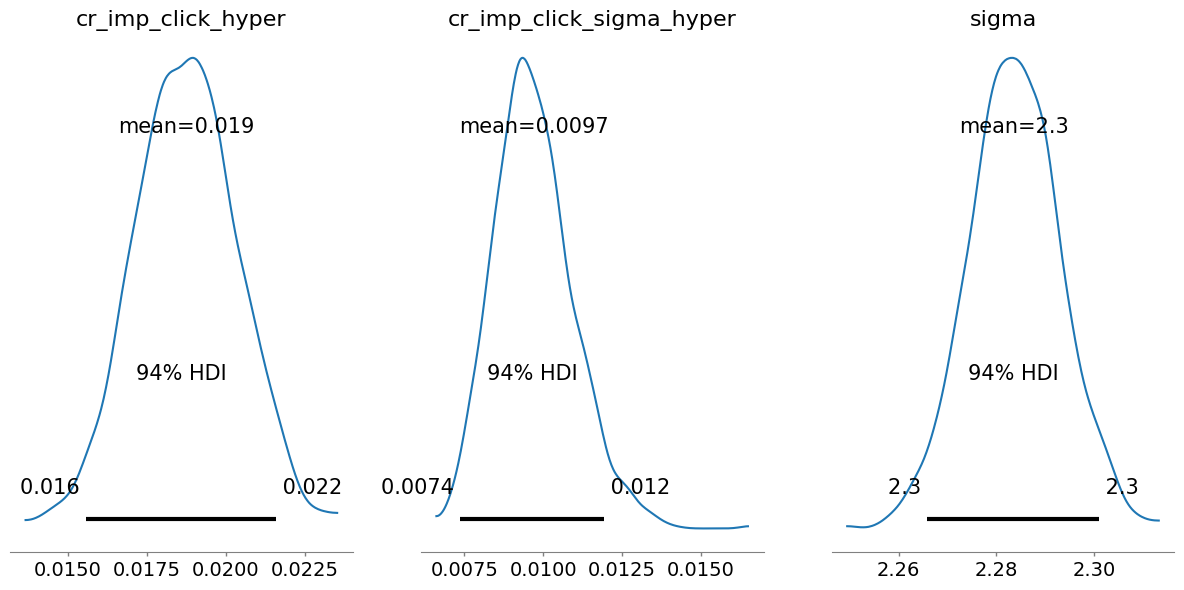

In [94]:
az.plot_posterior(
    trace_imp_click,
    var_names=['cr_imp_click_hyper', 'cr_imp_click_sigma_hyper','sigma'],
    figsize=(12, 6),
)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

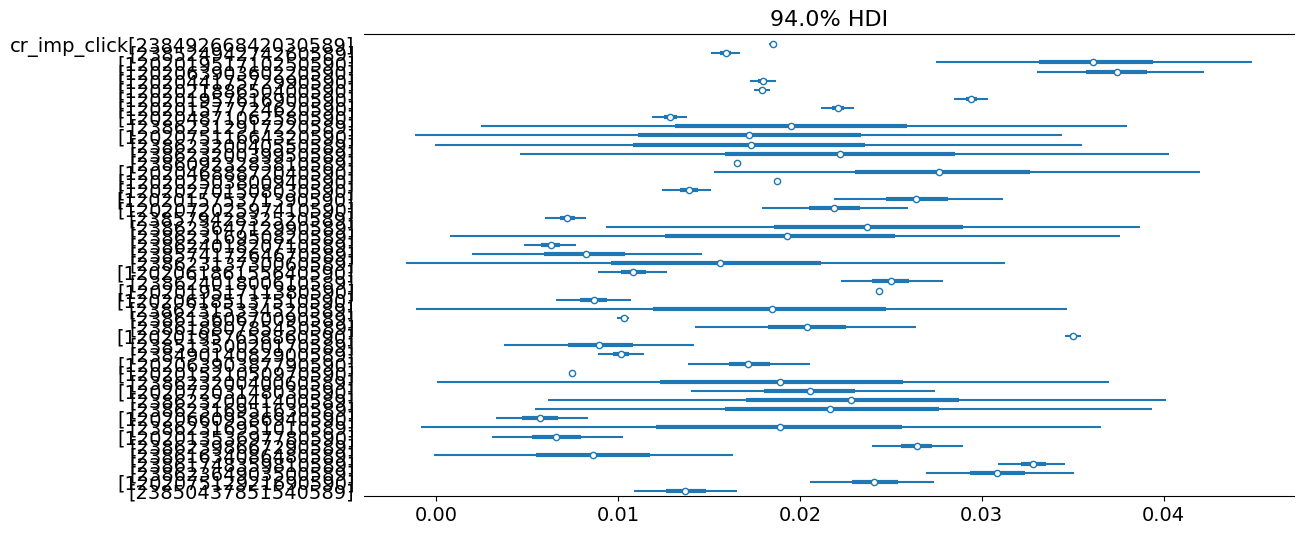

In [95]:
az.plot_forest(
    trace_imp_click,
    var_names=['cr_imp_click'],
    combined=True,
    figsize=(12, 6),
)

array([[<Axes: title={'center': 'cr_imp_click_hyper'}>,
        <Axes: title={'center': 'cr_imp_click_hyper'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'cr_imp_click'}>,
        <Axes: title={'center': 'cr_imp_click'}>]], dtype=object)

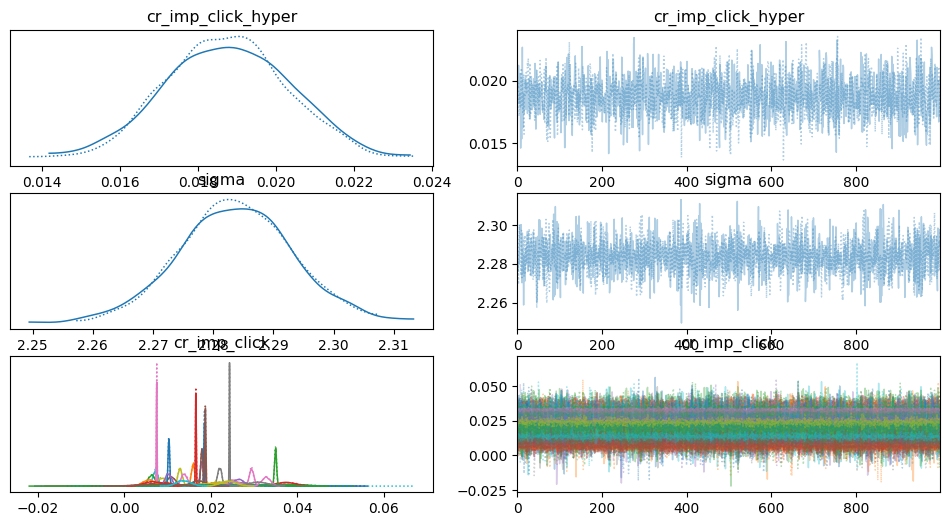

In [96]:
az.plot_trace(trace_imp_click, var_names=['cr_imp_click_hyper', 'sigma', 'cr_imp_click'])

# Model - purchases by way of modeled clicks

In [97]:
with pm.Model(coords={"ad_id": ad_ids}) as model_imp_purchase:
    # data
    impressions = pm.Data('impressions', facebook_slimmed['impressions'])
    
    # index of the ad in the ad_ids array - used for indexing the ad_id specific parameters
    ad_id_idx = facebook_slimmed['ad_id'].apply(lambda x: list(ad_ids).index(x))
    
    # priors
    cr_imp_click_hyper = pm.Normal('cr_imp_click_hyper', mu=0.02, sigma=0.02)
    # ad_id specific conversion rate
    cr_imp_click = pm.Normal('cr_imp_click', mu=cr_imp_click_hyper, sigma=0.02, dims="ad_id")   

    sigma_click = pm.HalfNormal('sigma_click', sigma=0.02)

    mu_click = pm.Deterministic('mu_click', cr_imp_click[ad_id_idx] * impressions)

    # likelihood
    clicks = pm.Normal('clicks', mu=mu_click, sigma=sigma_click, observed=facebook_slimmed['clicks'])

    cr_click_purchase_hyper = pm.Normal('cr_click_purchase_hyper', mu=0.02, sigma=0.02) 
    cr_click_purchase = pm.Normal('cr_click_purchase', mu=cr_click_purchase_hyper, sigma=0.02, dims="ad_id")   
    
    mu_purchase = pm.Deterministic('mu_purchase', cr_click_purchase[ad_id_idx] * clicks)

    sigma_purchase = pm.HalfNormal('sigma_purchase', sigma=0.02)

    purchase = pm.Normal('purchase', mu=mu_purchase, sigma=sigma_purchase, observed=facebook_slimmed['purchases'])
    
    
    trace_imp_purchase = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [cr_imp_click_hyper, cr_imp_click, sigma_click, cr_click_purchase_hyper, cr_click_purchase, sigma_purchase]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


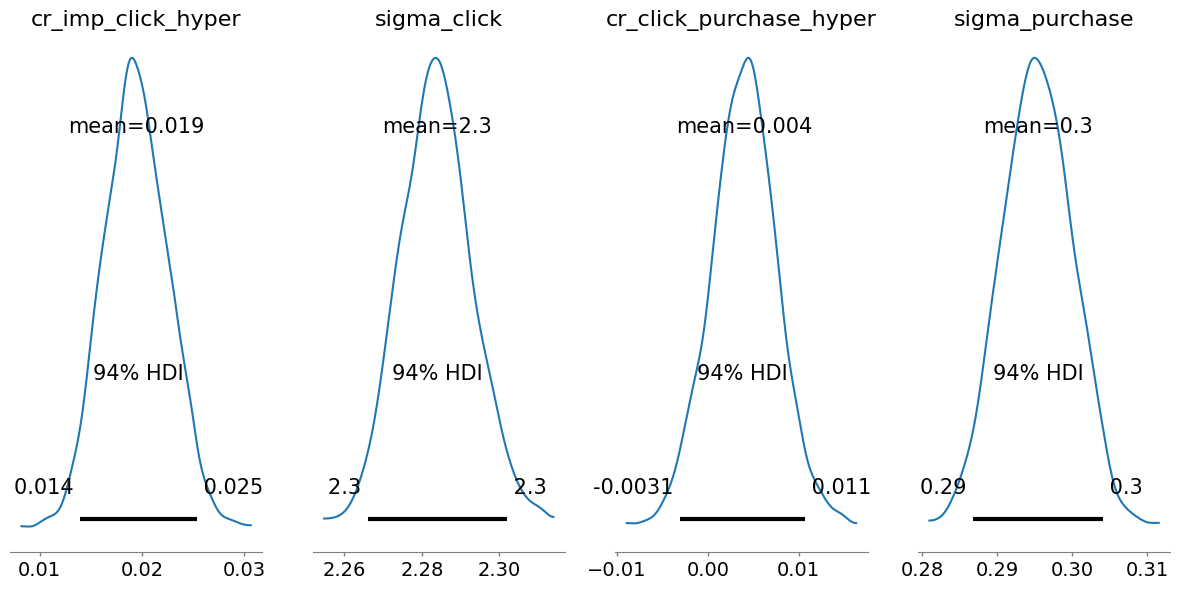

In [98]:
az.plot_posterior(
    trace_imp_purchase,
    var_names=['cr_imp_click_hyper', 'sigma_click', 'cr_click_purchase_hyper', 'sigma_purchase'],
    figsize=(12, 6),
)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

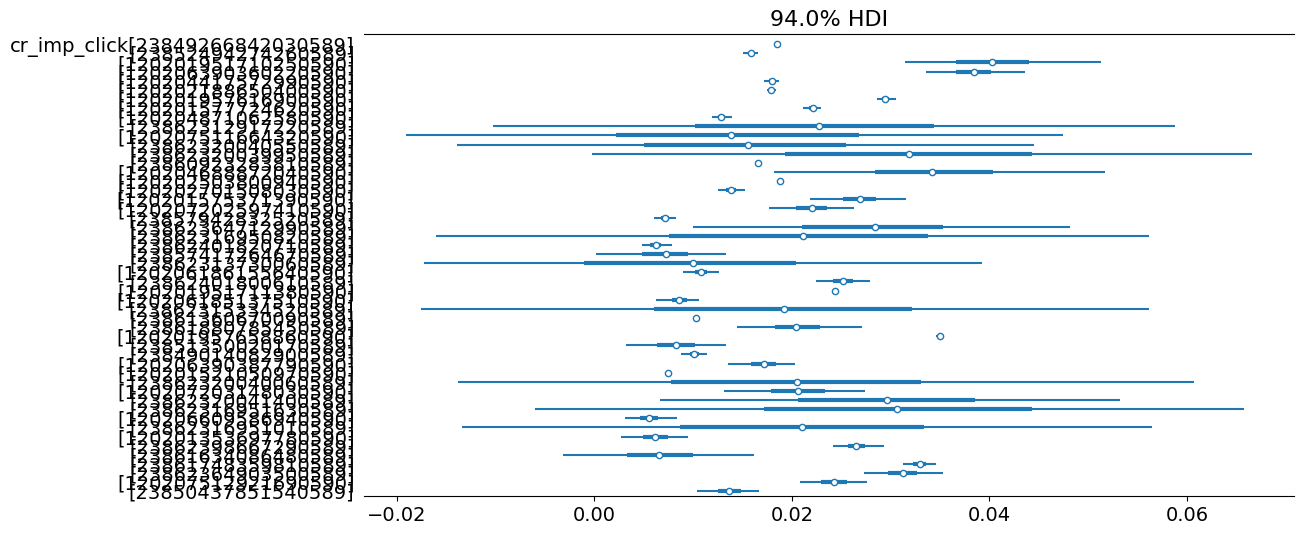

In [99]:
az.plot_forest(
    trace_imp_purchase,
    var_names=['cr_imp_click'],
    combined=True,
    figsize=(12, 6),
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

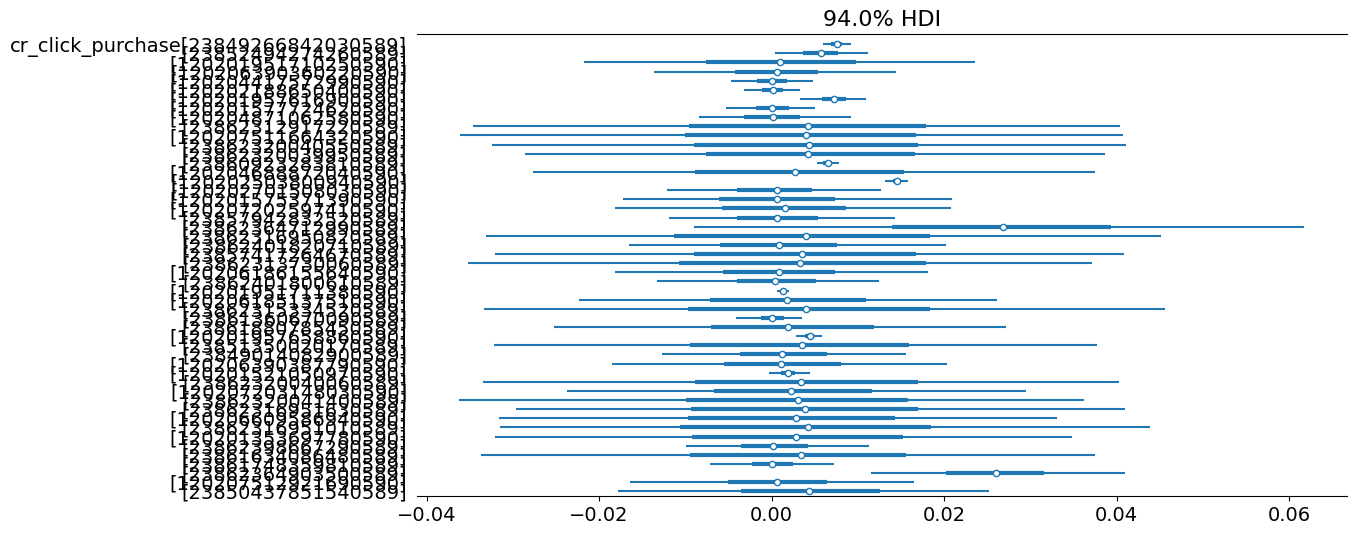

In [100]:
az.plot_forest(
    trace_imp_purchase,
    var_names=['cr_click_purchase'],
    combined=True,
    figsize=(12, 6),
)

array([[<Axes: title={'center': 'cr_imp_click_hyper'}>,
        <Axes: title={'center': 'cr_imp_click_hyper'}>],
       [<Axes: title={'center': 'sigma_click'}>,
        <Axes: title={'center': 'sigma_click'}>],
       [<Axes: title={'center': 'cr_imp_click'}>,
        <Axes: title={'center': 'cr_imp_click'}>]], dtype=object)

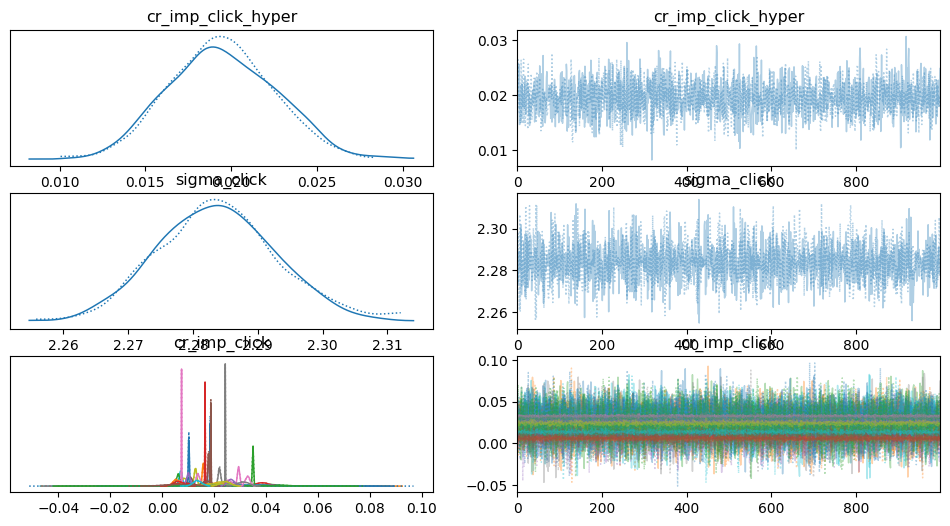

In [101]:
az.plot_trace(trace_imp_purchase, var_names=['cr_imp_click_hyper', 'sigma_click', 'cr_imp_click'])

array([[<Axes: title={'center': 'cr_click_purchase_hyper'}>,
        <Axes: title={'center': 'cr_click_purchase_hyper'}>],
       [<Axes: title={'center': 'sigma_purchase'}>,
        <Axes: title={'center': 'sigma_purchase'}>],
       [<Axes: title={'center': 'cr_click_purchase'}>,
        <Axes: title={'center': 'cr_click_purchase'}>]], dtype=object)

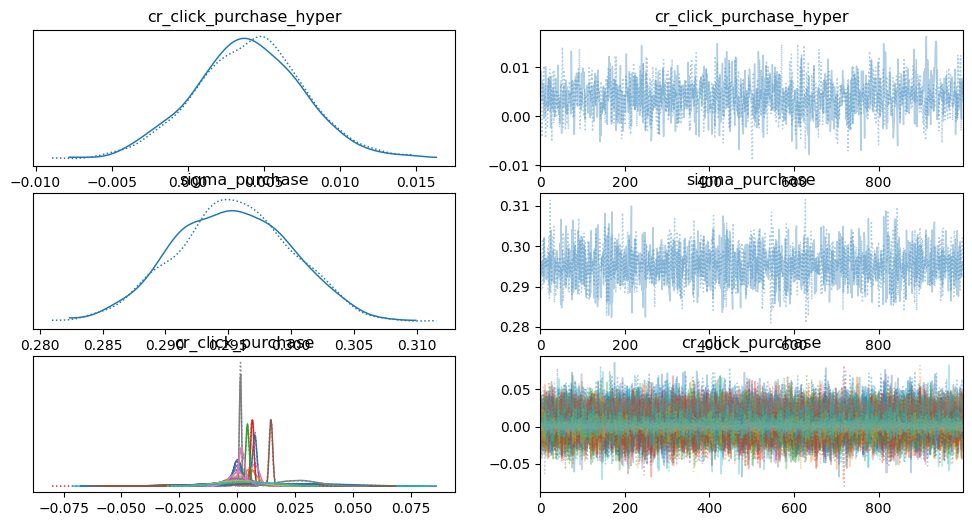

In [102]:
az.plot_trace(trace_imp_purchase, var_names=['cr_click_purchase_hyper', 'sigma_purchase', 'cr_click_purchase'])

In [103]:
trace_imp_purchase

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [104]:
trace_imp_purchase.posterior['cr_imp_click'].mean(dim=['chain', 'draw']).values.shape

(50,)

In [105]:
conv_rates = pd.DataFrame({
    'cr_imp_click': trace_imp_purchase.posterior['cr_imp_click'].mean(dim=['chain', 'draw']).values,
    'cr_click_purchase': trace_imp_purchase.posterior['cr_click_purchase'].mean(dim=['chain', 'draw']).values
})
conv_rates

,cr_imp_click,cr_click_purchase
0,0.018534,0.007538
1,0.015891,0.005656
2,0.040340,0.001073
3,0.038399,0.000640
4,0.017967,0.000034
5,0.017895,0.000080
6,0.029471,0.007203
7,0.022093,0.000059
8,0.012874,0.000132
9,0.022452,0.004143


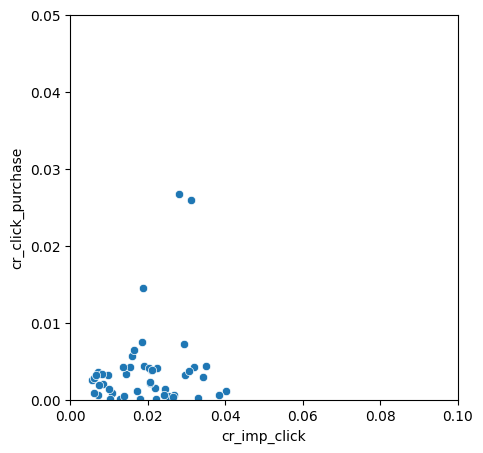

In [106]:
# scatter plot of the conversion rates
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=conv_rates, x='cr_imp_click', y='cr_click_purchase', ax=ax)
ax.set_xlim(left=0.0, right=0.1)
ax.set_ylim(bottom=0.0, top=0.05)
plt.show()

<Axes: >

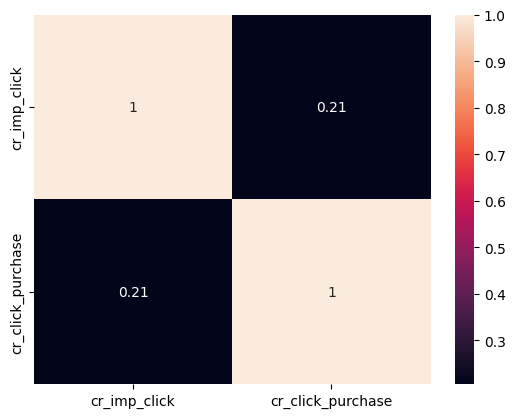

In [107]:
# correlation matrix of the conversion rates
conv_rates.corr()
# plot
sns.heatmap(conv_rates.corr(), annot=True)
